<a href="https://colab.research.google.com/github/FeraMaks/test/blob/main/16_Tensorboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F
from torch,utils,tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist')
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

#MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_test = torchvision.datasets.MNIST(root='./data', train=False,
          transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
          shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


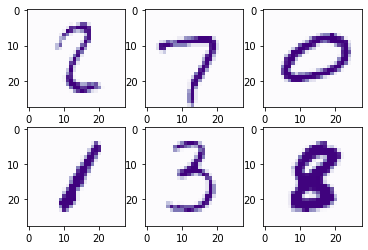

In [ ]:
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(samples[i][0],cmap='Purples')
  #plt.show
img_grid = torchvision.utils.make_grid(examples)
writer.add_image('mnist_images', img_grid)


In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out
model = NeuralNet(input_size, hidden_size, num_classes)

Loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
writer.add_graph(model, example_data.reshape(-1,28*28))
writer.close()
sys.exit()

Training loop

In [ ]:
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #100, 1, 28, 28
    #100,784)
    images = images.reshape(-1,28*28).to(device)
    labels = labels.to(device)

    #forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    #backwards
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predictions = torch.max(outputs, 1)
    running_correct += (predicted == labels).sum().item()
    if (i+1) % 100 == 0:
      print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
      writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
      writer.add_scalar('accuracy', running_correct / 100, epoch * n_total_steps + i)
      running_loss = 0.0
      running_correct = 0

epoch 1 / 2, step 100/600, loss = 0.4059
epoch 1 / 2, step 200/600, loss = 0.3356
epoch 1 / 2, step 300/600, loss = 0.1782
epoch 1 / 2, step 400/600, loss = 0.2654
epoch 1 / 2, step 500/600, loss = 0.2634
epoch 1 / 2, step 600/600, loss = 0.2289
epoch 2 / 2, step 100/600, loss = 0.2172
epoch 2 / 2, step 200/600, loss = 0.1499
epoch 2 / 2, step 300/600, loss = 0.1569
epoch 2 / 2, step 400/600, loss = 0.1054
epoch 2 / 2, step 500/600, loss = 0.2219
epoch 2 / 2, step 600/600, loss = 0.2602


Test

In [ ]:

labels = []
preds = []
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels1 in test_loader:
    images = images.reshape(-1,28*28).to(device)
    labels1 = labels1.to(device) 
    outputs = model(images)

    #value, index
    _, predictions = torch.max(outputs, 1)
    n_samples += labels1.shape[0]
    n_correct += (predictions == labels1).sum().item()

    class_predictions = [F.softmax(output, dim=0), for output in outputs]

    preds.append(class_predictions)
    labels.append(predicted)
  
  preds = torch.cat([torch.stack(batch) for batch in preds])
  labels = torch.cat(labels)

  acc = 100.0 * n_correct / n_samples
  print(f'accuracy = {acc}')

  classes = range(10)
  for i in classes:
    labels_i = labels == i
    preds_i = preds[:,i]
    writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
    writer.close()

In [ ]:
#acc = 100.0 * n_correct / n_samples
#print(f'accuracy = {acc}')

accuracy = 95.73666666666666
